# Implement a simple multivariate gaussian posterior with default values
Here we are using 2 parameters to show the effect of data with 0 mean and 0.1 * $I_{2}$ prior

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax.numpy.linalg import cholesky
from jax.scipy.linalg import inv
from scipy.stats import multivariate_normal

# Creation of dummy training data points using mu, sigma and n 

In [3]:
def gaussSample(mu, sigma, n, key):
    decomposition = cholesky(sigma)
    normal_distribution = jax.random.normal(key, shape=(len(mu), n))
    return jnp.dot(decomposition, normal_distribution).T + mu

In [4]:
def plot_data(x, muTrue, savename, title, fig=None, ax=None):
    marker_size = None
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x[:, 0], x[:, 1], "o", markerfacecolor="b")
    ax.set_ylim([-1, 1])
    # ax.set_xlim([-1, 1])
    ax.set_title(title)
    ax.set_xlabel("$y_1$")
    ax.set_ylabel("$y_2$")
    ax.plot(muTrue[0], muTrue[1], "x", markerfacecolor="black", color="k")

    sns.despine()
    # if len(savename) > 0:
    #     savefig(savename)
    return fig, ax

In [5]:
def make_contour_plot(x1, x2, p, savename, title, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    contour = ax.contourf(x1, x2, p)
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_ticks(jnp.linspace(p.min(), p.max(), 4))

    ax.set_ylim([-1, 1])
    ax.set_xlim([-1, 1])
    ax.set_title(title)
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    plt.gca().set_aspect("equal")
    sns.despine()
    # if len(savename) > 0:
    #     savefig(savename, tight_bbox=True)
    return fig, ax

In [1]:
data = {}
prior = {}
post = {}
key = jax.random.PRNGKey(5)

n_points = 10  # number of sample data points

# Part A
z = jnp.array([0.5, 0.5])
sigma_data = 0.1 * jnp.array([[2, 1], [1, 1]])

data["mu"] = z
data["Sigma"] = sigma_data
sample_points = gaussSample(data["mu"], data["Sigma"], n_points, key)
plot_data(sample_points, z, "gauss_2d_update_data", "Data")
xyrange = jnp.array([[-1, 1], [-1, 1]])
npoints = 100j
mesh = jnp.mgrid[xyrange[0, 0] : xyrange[0, 1] : npoints, xyrange[1, 0] : xyrange[1, 1] : npoints]
x1, x2 = mesh[0], mesh[1]
points = jnp.vstack([jnp.ravel(x1), jnp.ravel(x2)]).T

# Part B
def prior_pdf():
    prior["mu"] = jnp.array([0, 0])
    prior["Sigma"] = 0.1 * jnp.eye(2)
    prior_pdf = multivariate_normal.pdf(points, mean=prior["mu"], cov=prior["Sigma"]).reshape(x1.shape[0], x2.shape[0])
    return prior_pdf

# Part C
def post_pdf(sample_points):
    data_after_n = sample_points[:n_points, :]
    s0_inv = inv(prior["Sigma"])
    s_inv = inv(sigma_data)
    post["Sigma"] = inv(s0_inv + n_points * s_inv)
    mean = jnp.mean(data_after_n, 0)
    post["mu"] = jnp.dot(post["Sigma"], (jnp.dot(n_points, jnp.dot(s_inv, mean)) + jnp.dot(s0_inv, prior["mu"])))
    post_pdf = multivariate_normal.pdf(points, mean=post["mu"], cov=post["Sigma"]).reshape(x1.shape[0], x2.shape[0])
    return post_pdf
    
make_contour_plot(x1, x2, prior_pdf(), "gauss_2d_update_prior", "Prior")
make_contour_plot(x1, x2, post_pdf(sample_points), "gauss_2d_update_post", "Posterior after " + str(n_points) + " points")

NameError: name 'jax' is not defined

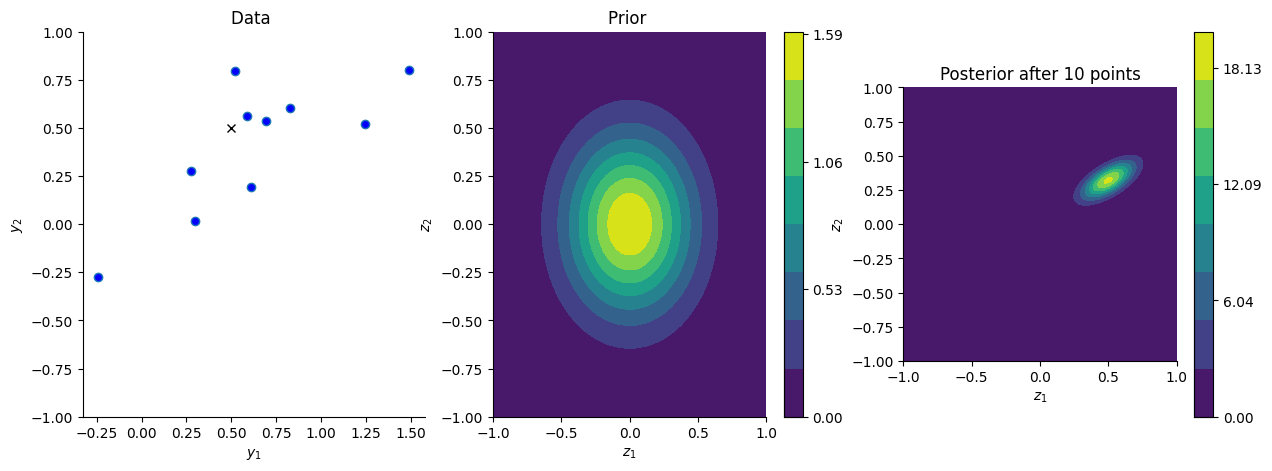

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plot_data(sample_points, z, "", "Data ", fig=fig, ax=ax1)
make_contour_plot(x1, x2, prior_pdf(), "", "Prior ", fig=fig, ax=ax2)
make_contour_plot(x1, x2, post_pdf(sample_points), "", "Posterior after " + str(n_points) + " points", fig=fig, ax=ax3)
plt.show()

In [23]:
from ipywidgets import interact


@interact(random_state=(1, 10), n_=(1, 20))
def generate_random(random_state, n_=10):
    key = jax.random.PRNGKey(random_state)
    sample_points = gaussSample(data["mu"], data["Sigma"], n_, key)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    plot_data(sample_points, z, "", "Data ", fig=fig, ax=ax1)
    make_contour_plot(x1, x2, prior_pdf(), "", "Prior ", fig=fig, ax=ax2)
    make_contour_plot(x1, x2, post_pdf(sample_points), "", "Posterior after " + str(n_points) + " points", fig=fig, ax=ax3)
    plt.show()

interactive(children=(IntSlider(value=5, description='random_state', max=10, min=1), IntSlider(value=10, descr…